In [ ]:
# Google Driveと接続を行います。これを行うことで、Driveにあるデータにアクセスできるようになります。
# 下記セルを実行すると、Googleアカウントのログインを求められますのでログインしてください。
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 作業フォルダへの移動を行います。
# 人によって作業場所がことなるので、その場合作業場所を変更してください。
import os 
os.chdir('/content/drive/MyDrive/100knock-data_analytics/4章') #ここを変更。

# 4章 顧客の全体像を把握する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析していきます。  
３章で顧客の全体像を把握しました。  
ここからは、機械学習を用いて顧客のグループ化や顧客の利用予測行なっていきましょう。  
ここでは、教師なし学習、教師あり学習の回帰を取り扱います。

### ノック31：データを読み込んで確認しよう

In [1]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [2]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### ノック32：クラスタリングで顧客をグループ化しよう

In [3]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering = customer_clustering.assign(cluster = clusters.labels_)

print(customer_clustering['cluster'].unique())
customer_clustering.head()

[1 2 0 3]


/Users/kuramotoyuuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,月内平均値,月内中央値,月内最大値,月内最少値,会員期間,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


### ノック33：クラスタリング結果を分析しよう

In [7]:
customer_clustering.columns = ['月内平均値', '月内中央値', '月内最大値', '月内最少値', '会員期間', 'cluster']
customer_clustering.groupby('cluster').count()

,月内平均値,月内中央値,月内最大値,月内最少値,会員期間
cluster,,,,,
0,1334,1334,1334,1334,1334
1,1249,1249,1249,1249,1249
2,763,763,763,763,763
3,846,846,846,846,846


In [8]:
customer_clustering.groupby('cluster').mean()

,月内平均値,月内中央値,月内最大値,月内最少値,会員期間
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,4.677494,4.671337,7.232986,2.153723,36.915933
2,3.054713,2.888598,4.756225,1.653997,9.263434
3,8.054608,8.039598,10.009456,6.160757,7.072104


### ノック34：クラスタリング結果を可視化してみよう

In [9]:
from sklearn.decomposition import PCA

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

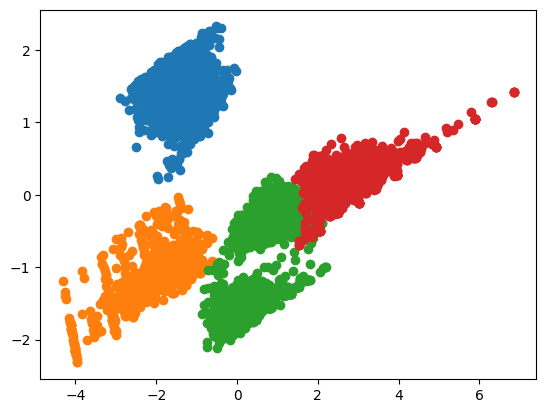

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster']==i]
    plt.scatter(tmp[0], tmp[1])

### ノック35：クラスタリング結果をもとに退会顧客の傾向を把握しよう

In [11]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,0,1230
3,1,1,19
4,2,1,763
5,3,0,827
6,3,1,19


In [12]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,228
1,0,1,1106
2,1,0,2
3,1,1,1247
4,2,0,497
5,2,1,266
6,3,0,52
7,3,1,794


### ノック36：翌月の利用回数予測を行うためのデータ準備をしよう

In [13]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime('%Y%m')

uselog_month = uselog.groupby(['年月', 'customer_id'], as_index=False).count()
uselog_month.rename(columns={'log_id':'count'}, inplace=True)

del uselog_month['usedate']
uselog_month.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [15]:
year_months = list(uselog_month['年月'].unique())
predict_data = pd.DataFrame()

for i in range(6, len(year_months)):
    tmp = uselog_month.loc[uselog_month['年月']==year_months[i]].copy()
    tmp.rename(columns={'count':'count_pred'}, inplace=True)

    for j in range(1, 7):
        tmp_before = uselog_month.loc[uselog_month['年月']==year_months[i-j]].copy()
        del tmp_before['年月']
        tmp_before.rename(columns={'count':'count_{}'.format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')

    predict_data = pd.concat([predict_data, tmp], ignore_index=True)

predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [16]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### ノック37：特徴となる変数を付与しよう

In [17]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [18]:
predict_data['now_date'] = pd.to_datetime(predict_data['年月'], format='%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

from dateutil.relativedelta import relativedelta

predict_data['period'] = None

for i in range(len(predict_data)):
    delta = relativedelta(predict_data.loc[i, 'now_date'], predict_data.loc[i, 'start_date'])
    predict_data.loc[i, 'period'] = delta.years*12 + delta.months

predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### ノック38：来月の利用回数予測モデルを作成しよう

In [19]:
predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime('20180401')]

from sklearn import linear_model
import sklearn.model_selection

model = linear_model.LinearRegression()
X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_data['count_pred']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
model.fit(X_train, y_train)

LinearRegression()

In [20]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6111525903215709
0.5964633323568844


### ノック39：モデルに寄与している変数を確認しよう

In [21]:
coef = pd.DataFrame({'feature_names':X.columns, 'coefficient':model.coef_})
coef

,feature_names,coefficient
0,count_0,0.359133
1,count_1,0.181937
2,count_2,0.151177
3,count_3,0.184593
4,count_4,0.076946
5,count_5,0.058731
6,period,0.047007


### ノック40：来月の利用回数を予測しよう

In [24]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]

x_pred = pd.DataFrame(data=[x1, x2], columns=['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period'])

In [25]:
model.predict(x_pred)

array([3.77011036, 1.97563148])

In [26]:
uselog_month.to_csv('use_log_months.csv', index=False)